In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Employers_data.csv')


In [2]:
df.info()
df.columns
df.describe
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Employee_ID       10000 non-null  int64 
 1   Name              10000 non-null  object
 2   Age               10000 non-null  int64 
 3   Gender            10000 non-null  object
 4   Department        10000 non-null  object
 5   Job_Title         10000 non-null  object
 6   Experience_Years  10000 non-null  int64 
 7   Education_Level   10000 non-null  object
 8   Location          10000 non-null  object
 9   Salary            10000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


,Employee_ID,Name,Age,Gender,Department,Job_Title,Experience_Years,Education_Level,Location,Salary
0,1,Merle Ingram,24,Female,Engineering,Engineer,1,Master,Austin,90000
1,2,John Mayes,56,Male,Sales,Executive,33,Master,Seattle,195000
2,3,Carlos Wille,21,Male,Engineering,Intern,1,Bachelor,New York,35000
3,4,Michael Bryant,30,Male,Finance,Analyst,9,Bachelor,New York,75000
4,5,Paula Douglas,25,Female,HR,Analyst,2,Master,Seattle,70000


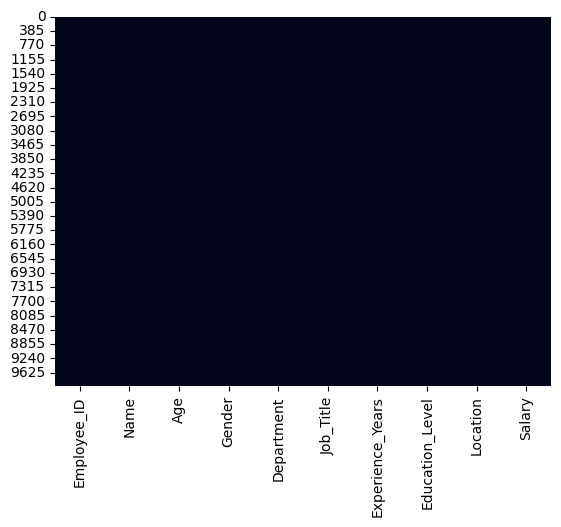

In [3]:
sns.heatmap(df.isnull(), cbar=False)
plt.show()

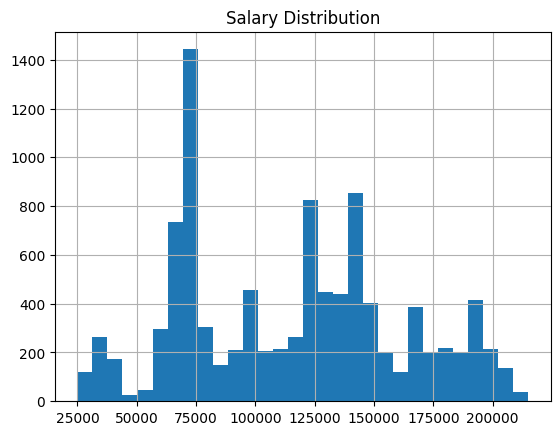

In [4]:
df['Salary'].hist(bins=30)
plt.title('Salary Distribution')
plt.show()


Department
Product        1724
Engineering    1683
Sales          1669
Marketing      1669
HR             1660
Finance        1595
Name: count, dtype: int64


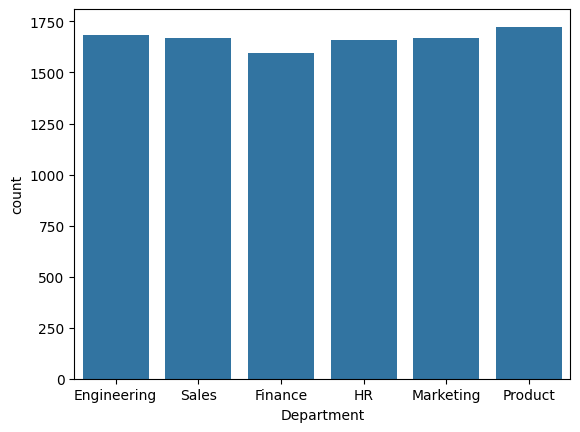

In [5]:
print(df['Department'].value_counts())
sns.countplot(x='Department', data=df)
plt.show()


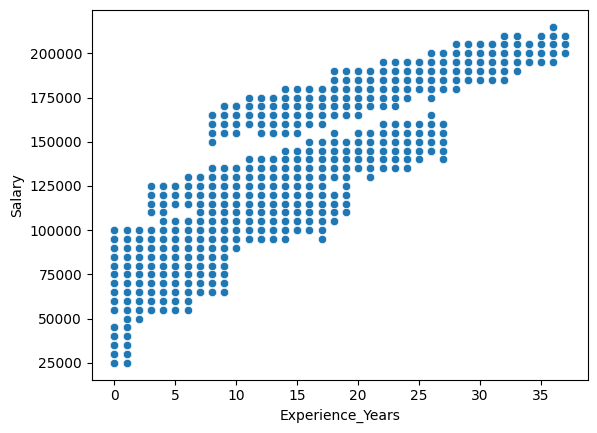

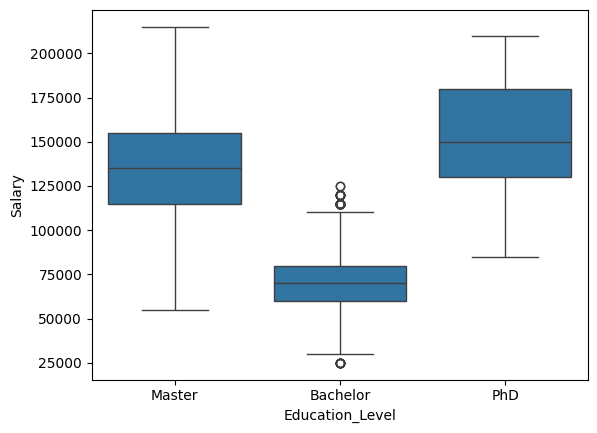

In [6]:
sns.scatterplot(x='Experience_Years', y='Salary', data=df)
plt.show()

sns.boxplot(x='Education_Level', y='Salary', data=df)
plt.show()


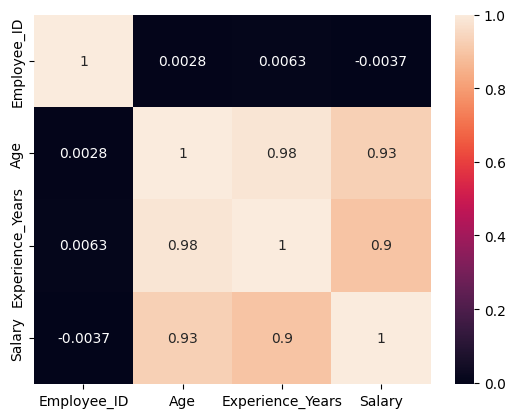

In [7]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True)
plt.show()

In [8]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['Department_encoded'] = le.fit_transform(df['Department'])
# Repeat for other categorical columns as needed


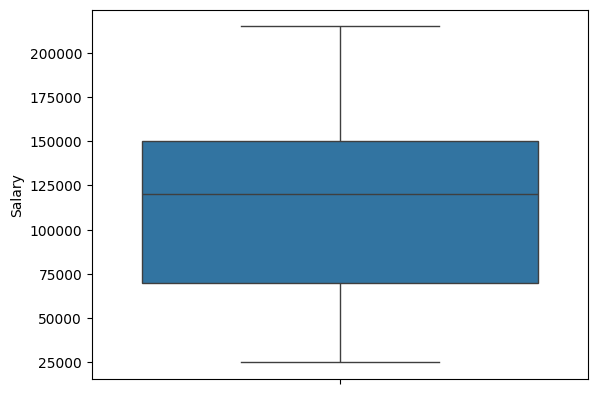

In [9]:
sns.boxplot(y='Salary', data=df)
plt.show()

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = ['Gender', 'Department', 'Job_Title', 'Education_Level', 'Location']
numeric_features = ['Age', 'Experience_Years']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])


In [11]:
X = df.drop('Salary', axis=1)
y = df['Salary']


In [12]:
X_processed = preprocessor.fit_transform(X)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

# Train models
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Predictions
y_pred_lr = lr.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Metrics


import numpy as np

mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
print('Linear Regression RMSE:', rmse_lr)

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print('Random Forest RMSE:', rmse_rf)
# print('Linear Regression RMSE:', mean_squared_error(y_test, y_pred_lr, squared=False))
print('Linear Regression R2:', r2_score(y_test, y_pred_lr))

# print('Random Forest RMSE:', mean_squared_error(y_test, y_pred_rf, squared=False))
print('Random Forest R2:', r2_score(y_test, y_pred_rf))





Linear Regression RMSE: 4168.335593686901
Random Forest RMSE: 4900.989967608985
Linear Regression R2: 0.9917562580370475
Random Forest R2: 0.9886036267988741


In [16]:
import numpy as np

feature_names_num = numeric_features
feature_names_cat = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([feature_names_num, feature_names_cat])

importances = rf.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

for idx in sorted_indices[:10]:  # top 10 features
    print(f'{feature_names[idx]}: {importances[idx]}')

Age: 0.7529452825075581
Job_Title_Executive: 0.17085396640754186
Job_Title_Intern: 0.03643943286303806
Job_Title_Analyst: 0.018895432555011492
Job_Title_Manager: 0.0072454188546159605
Job_Title_Engineer: 0.006781401730352299
Experience_Years: 0.0024723830679837205
Gender_Female: 0.000395343759825171
Location_Austin: 0.0003925750469056932
Gender_Male: 0.0003920479452969413


In [17]:
from sklearn.model_selection import cross_val_score

# Cross-validation (5 folds)
scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Random Forest CV RMSE (default):", -scores.mean())


Random Forest CV RMSE (default): 4899.717697219592


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees
    'max_depth': [None, 10, 20, 30],      # Maximum tree depth
    'min_samples_split': [2, 5, 10],      # Min samples required to split
    'min_samples_leaf': [1, 2, 4]         # Min samples per leaf
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print('Best hyperparameters:', grid_search.best_params_)
print('Best CV RMSE:', -grid_search.best_score_)


Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best CV RMSE: 4459.335756797262


In [19]:
best_rf = grid_search.best_estimator_

y_pred_best_rf = best_rf.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2 = r2_score(y_test, y_pred_best_rf)

print("Tuned Random Forest Test RMSE:", rmse)
print("Tuned Random Forest Test R2:", r2)


Tuned Random Forest Test RMSE: 4340.339505585878
Tuned Random Forest Test R2: 0.9910618746840751


In [20]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np

ridge = Ridge()

# Hyperparameter grid for Ridge
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best Ridge hyperparameters:', grid_search.best_params_)
print('Best Ridge CV RMSE:', -grid_search.best_score_)


Best Ridge hyperparameters: {'alpha': 0.01}
Best Ridge CV RMSE: 4292.6912885491665


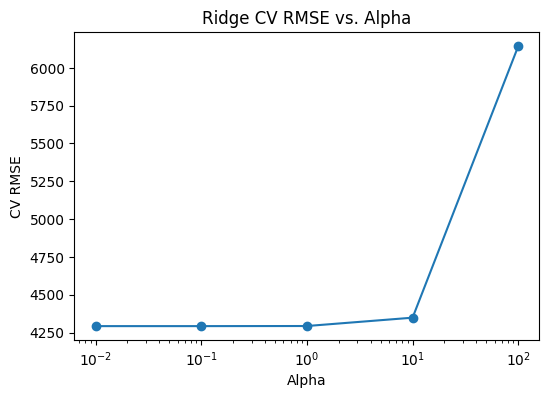

In [21]:
import matplotlib.pyplot as plt

# Results from GridSearchCV
results = grid_search.cv_results_
alphas = results['param_alpha'].data
mean_rmse = -results['mean_test_score']

plt.figure(figsize=(6,4))
plt.plot(alphas, mean_rmse, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('CV RMSE')
plt.title('Ridge CV RMSE vs. Alpha')
plt.show()


In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(50, 201, 10),
    'max_depth': [None] + list(np.arange(5, 31, 5)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,             # number of random parameter settings sampled
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)
print('Best Random Forest parameters (RandomizedSearchCV):', random_search.best_params_)
print('Best Random Forest CV RMSE:', -random_search.best_score_)


Best Random Forest parameters (RandomizedSearchCV): {'n_estimators': 80, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Best Random Forest CV RMSE: 4480.32744260807


In [23]:
from skopt import BayesSearchCV

bayes_search = BayesSearchCV(
    estimator=rf,
    search_spaces=param_dist,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)
print('Best RF params (BayesSearchCV):', bayes_search.best_params_)
print('Best RF CV RMSE:', -bayes_search.best_score_)


Best RF params (BayesSearchCV): OrderedDict([('max_depth', 10), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 190)])
Best RF CV RMSE: 4459.436834904138


In [24]:
pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [25]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(max_iter=10000)

param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)
print('Best Lasso hyperparameters:', grid_search.best_params_)
print('Best Lasso CV RMSE:', -grid_search.best_score_)


Best Lasso hyperparameters: {'alpha': 1}
Best Lasso CV RMSE: 4292.299808829519


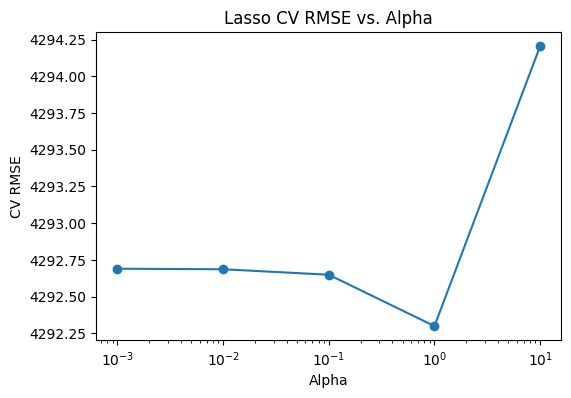

In [26]:
import matplotlib.pyplot as plt

results = grid_search.cv_results_
alphas = results['param_alpha'].data
mean_rmse = -results['mean_test_score']

plt.figure(figsize=(6,4))
plt.plot(alphas, mean_rmse, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('CV RMSE')
plt.title('Lasso CV RMSE vs. Alpha')
plt.show()


In [27]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

svr = SVR()

param_dist = {
    'C': np.logspace(-1, 2, 10),
    'epsilon': np.logspace(-3, 0, 10),
    'kernel': ['linear', 'rbf']
}

random_search = RandomizedSearchCV(
    estimator=svr,
    param_distributions=param_dist,
    n_iter=15,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
print('Best SVR parameters:', random_search.best_params_)
print('Best SVR CV RMSE:', -random_search.best_score_)


Best SVR parameters: {'kernel': 'linear', 'epsilon': 0.0021544346900318843, 'C': 100.0}
Best SVR CV RMSE: 5411.879730136197


In [28]:
from skopt import BayesSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

search_spaces = {
    'n_estimators': (50, 300),
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.2, 'log-uniform'),
    'subsample': (0.6, 1.0, 'uniform')
}

bayes_search = BayesSearchCV(
    estimator=gbr,
    search_spaces=search_spaces,
    n_iter=20,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
bayes_search.fit(X_train, y_train)
print('Best GradientBoostingRegressor params:', bayes_search.best_params_)
print('Best GBR CV RMSE:', -bayes_search.best_score_)


Best GradientBoostingRegressor params: OrderedDict([('learning_rate', 0.11221552392513007), ('max_depth', 4), ('n_estimators', 201), ('subsample', 0.9433926163328545)])
Best GBR CV RMSE: 4385.907872886292


In [29]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# Define the regressor
knn = KNeighborsRegressor()

# Set up the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1=Manhattan, 2=Euclidean
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

print("Best KNN params:", grid_search.best_params_)
print("Best KNN CV RMSE:", -grid_search.best_score_)


Best KNN params: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Best KNN CV RMSE: 5225.298227653033


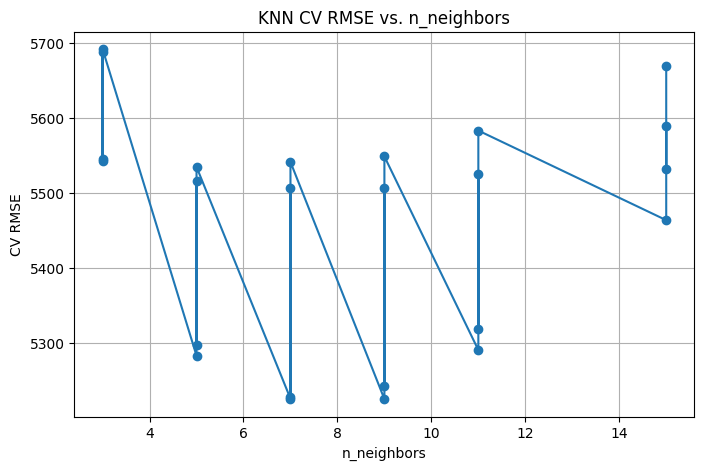

In [30]:
import matplotlib.pyplot as plt
import numpy as np
results = grid_search.cv_results_

# Extract data for plotting
mean_rmse = -results['mean_test_score']
n_neighbors = results['param_n_neighbors'].data

plt.figure(figsize=(8,5))
plt.plot(n_neighbors, mean_rmse, 'o-')
plt.xlabel('n_neighbors')
plt.ylabel('CV RMSE')
plt.title('KNN CV RMSE vs. n_neighbors')
plt.grid(True)
plt.show()


In [31]:
# Best estimator from grid search
best_knn = grid_search.best_estimator_

# Predict on test set
y_pred = best_knn.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Tuned KNN Test RMSE:", rmse)
print("Tuned KNN Test R2:", r2)


Tuned KNN Test RMSE: 5022.802940860416
Tuned KNN Test R2: 0.9880300781351431


In [32]:
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_grid,
    n_iter=12,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
print("Best KNN params (RandomizedSearchCV):", random_search.best_params_)
print("Best KNN CV RMSE:", -random_search.best_score_)


Best KNN params (RandomizedSearchCV): {'weights': 'uniform', 'p': 1, 'n_neighbors': 9}
Best KNN CV RMSE: 5225.298227653033


In [33]:
import pandas as pd

# Load data
df = pd.read_csv('Employers_data.csv')
df.columns = df.columns.str.strip()  # Remove whitespace from headers

# Separate target
target = 'Salary'

# Automatically get categorical and numeric features
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target from features list
if target in numeric_features:
    numeric_features.remove(target)
if target in categorical_features:
    categorical_features.remove(target)

print("Categorical:", categorical_features)
print("Numeric:", numeric_features)

X = df.drop(columns=[target])
y = df[target]

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

param_grid = {
    'regressor__n_neighbors': [3, 5, 7, 9, 11, 15],
    'regressor__weights': ['uniform', 'distance'],
    'regressor__p': [1, 2]
}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    error_score='raise'  # helpful to raise error immediately for debugging
)

grid_search.fit(X_train, y_train)


Categorical: ['Name', 'Gender', 'Department', 'Job_Title', 'Education_Level', 'Location']
Numeric: ['Employee_ID', 'Age', 'Experience_Years']


,estimator,Pipeline(step...Regressor())])
,param_grid,"{'regressor__n_neighbors': [3, 5, ...], 'regressor__p': [1, 2], 'regressor__weights': ['uniform', 'distance']}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,'raise'
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


Test RMSE: 5089.49
Test R2 Score: 0.99


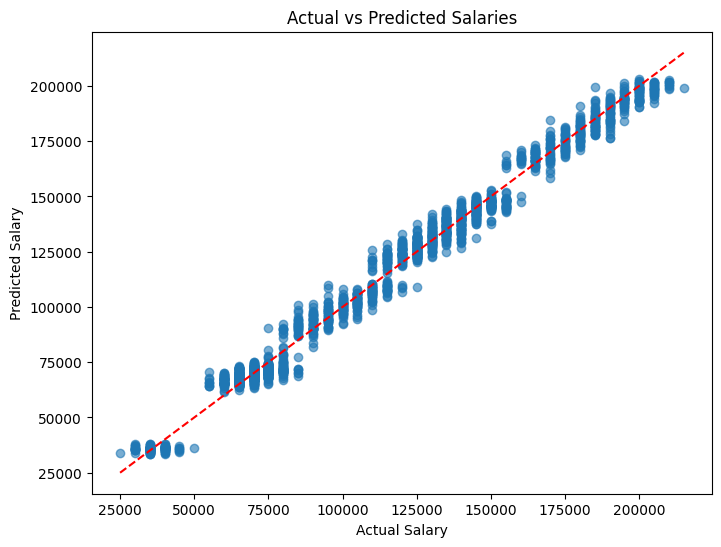

In [34]:
# Use the best estimator (pipeline with preprocessing + regressor)
best_model = grid_search.best_estimator_

# Predict on test set features
y_pred = best_model.predict(X_test)

# Evaluate performance
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R2 Score: {r2:.2f}")

# Optional: compare predictions vs actual values visually
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # identity line
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs Predicted Salaries')
plt.show()


In [35]:
# import joblib

# # Save pipeline
# joblib.dump(best_model, 'knn_salary_pipeline.pkl')
# print("Model saved to knn_salary_pipeline.pkl")

# # Later, load the model
# loaded_model = joblib.load('knn_salary_pipeline.pkl')

# # Use loaded model to predict
# new_preds = loaded_model.predict(new_samples)
# print("Predictions from loaded model:", new_preds)


# # import joblib

# # joblib.dump(pipeline, 'salary_model_no_id.pkl')
# # print("Model pipeline saved without ID columns as 'salary_model_no_id.pkl'")


In [36]:
import pandas as pd
import joblib

model = joblib.load('knn_salary_pipeline.pkl')

# Example: New employees data (make sure columns match your original features exactly)
new_samples = pd.DataFrame([
    {
        'Employee_ID': 10001,
        'Name': 'ABC',
        'Age': 40,
        'Experience_Years': 15,
        'Gender': 'Male',
        'Department': 'Sales',
        'Job_Title': 'Sales Executive',
        'Education_Level': 'PhD',
        'Location': 'New York'
    },
    {
        'Employee_ID': 10002,
        'Name': 'XYZ',
        'Age': 45,
        'Experience_Years': 20,
        'Gender': 'Female',
        'Department': 'Engineering',
        'Job_Title': 'Senior Engineer',
        'Education_Level': 'Master',
        'Location': 'San Francisco'
    }
])

# Predict salaries
predicted_salaries = best_model.predict(new_samples)

# Print results
for i, salary in enumerate(predicted_salaries):
    print(f"Predicted salary for sample {i+1}: ${salary:,.2f}")


Predicted salary for sample 1: $166,910.38
Predicted salary for sample 2: $139,986.92


In [37]:
import numpy as np
import pandas as pd

# Extract the KNN step from your pipeline
knn_model = best_model.named_steps['regressor']
preprocessor = best_model.named_steps['preprocessor']

# Preprocess training data (transform feature matrix)
X_train_processed = preprocessor.transform(X_train)

def explain_knn_prediction(sample_df, k=5):
    # Transform new sample
    sample_processed = preprocessor.transform(sample_df)

    # Find distances and indices of neighbors
    distances, indices = knn_model.kneighbors(sample_processed, n_neighbors=k)

    for i, (dist, idx) in enumerate(zip(distances, indices)):
        print(f"\nFor sample {i+1}:")
        print(f"Input features:\n{sample_df.iloc[i].to_dict()}")
        print("Nearest Neighbors and distances:")

        # Retrieve neighbor rows and distances
        neighbors = X_train.iloc[idx]
        neighbors['Salary'] = y_train.iloc[idx]
        neighbors['Distance'] = dist
        display(neighbors)

# Example usage on your new_samples DataFrame
explain_knn_prediction(new_samples, k=5)



For sample 1:
Input features:
{'Employee_ID': 10001, 'Name': 'ABC', 'Age': 40, 'Experience_Years': 15, 'Gender': 'Male', 'Department': 'Sales', 'Job_Title': 'Sales Executive', 'Education_Level': 'PhD', 'Location': 'New York'}
Nearest Neighbors and distances:


C:\Users\Bharath T\AppData\Local\Temp\ipykernel_11592\1724477980.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['Salary'] = y_train.iloc[idx]
C:\Users\Bharath T\AppData\Local\Temp\ipykernel_11592\1724477980.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['Distance'] = dist


,Employee_ID,Name,Age,Gender,Department,Job_Title,Experience_Years,Education_Level,Location,Salary,Distance
9910,9911,Dewayne Macon,42,Male,Sales,Executive,15,PhD,New York,175000,2.230932
9075,9076,Louis Myers,42,Male,Sales,Executive,15,PhD,New York,170000,2.520112
8913,8914,Robert Stokes,40,Male,Sales,Executive,13,PhD,New York,170000,2.594539
7746,7747,Steve Warner,43,Male,Sales,Executive,16,PhD,New York,175000,3.189301
8954,8955,Casey Shotkoski,36,Male,Sales,Executive,9,PhD,New York,160000,3.416035



For sample 2:
Input features:
{'Employee_ID': 10002, 'Name': 'XYZ', 'Age': 45, 'Experience_Years': 20, 'Gender': 'Female', 'Department': 'Engineering', 'Job_Title': 'Senior Engineer', 'Education_Level': 'Master', 'Location': 'San Francisco'}
Nearest Neighbors and distances:


C:\Users\Bharath T\AppData\Local\Temp\ipykernel_11592\1724477980.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['Salary'] = y_train.iloc[idx]
C:\Users\Bharath T\AppData\Local\Temp\ipykernel_11592\1724477980.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neighbors['Distance'] = dist


,Employee_ID,Name,Age,Gender,Department,Job_Title,Experience_Years,Education_Level,Location,Salary,Distance
7184,7185,Tracie Sanchez,44,Female,Engineering,Manager,21,Master,San Francisco,140000,3.184519
7103,7104,Cara Peters,46,Female,Engineering,Manager,23,Master,San Francisco,150000,3.430656
6438,6439,Betty Bell,42,Female,Engineering,Manager,19,Master,San Francisco,135000,3.642639
9167,9168,Rose Bridges,37,Female,Engineering,Manager,14,Master,San Francisco,125000,3.742139
6767,6768,Bethann Gomez,40,Female,Engineering,Manager,17,Master,San Francisco,135000,3.946546


In [38]:
import joblib

# Save pipeline
joblib.dump(best_model, 'knn_salary_pipeline.pkl')
print("Model saved to knn_salary_pipeline.pkl")

# Later, load the model
loaded_model = joblib.load('knn_salary_pipeline.pkl')

# Use loaded model to predict
new_preds = loaded_model.predict(new_samples)
print("Predictions from loaded model:", new_preds)


Model saved to knn_salary_pipeline.pkl
Predictions from loaded model: [166910.375707   139986.92273972]


In [39]:
# Example: Combine existing features
df['Experience_per_Age'] = df['Experience_Years'] / df['Age']   # Ratio of experience to age
df['Is_Manager'] = df['Job_Title'].str.contains('Manager', case=False).astype(int)  # Flag if the employee is a manager

# You can then repeat your train/test split and pipeline as before, including these columns.


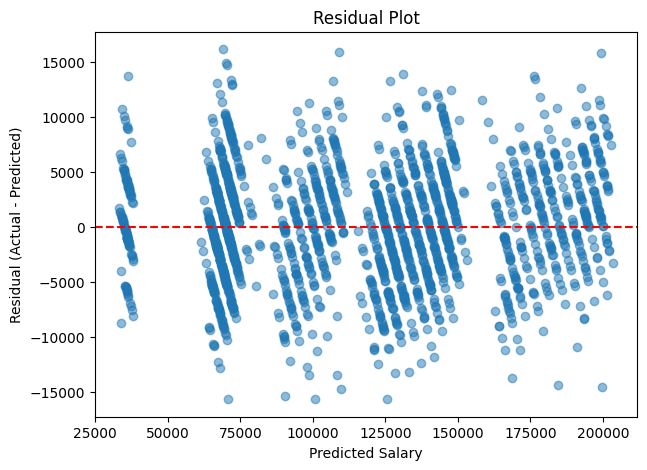

In [40]:
import matplotlib.pyplot as plt

residuals = y_test - y_pred

plt.figure(figsize=(7,5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Salary')
plt.ylabel('Residual (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()


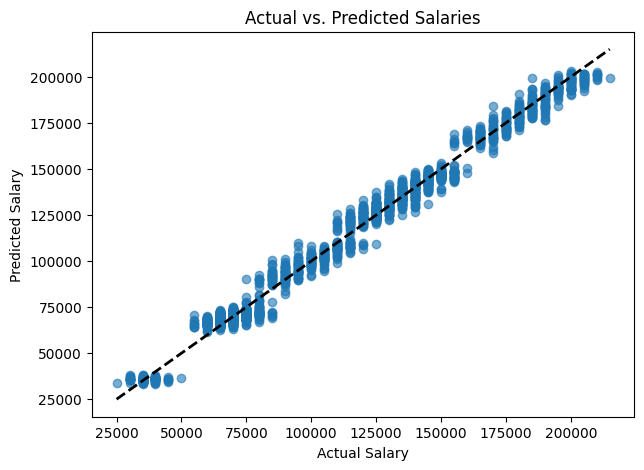

In [41]:
plt.figure(figsize=(7,5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Salary')
plt.ylabel('Predicted Salary')
plt.title('Actual vs. Predicted Salaries')
plt.show()


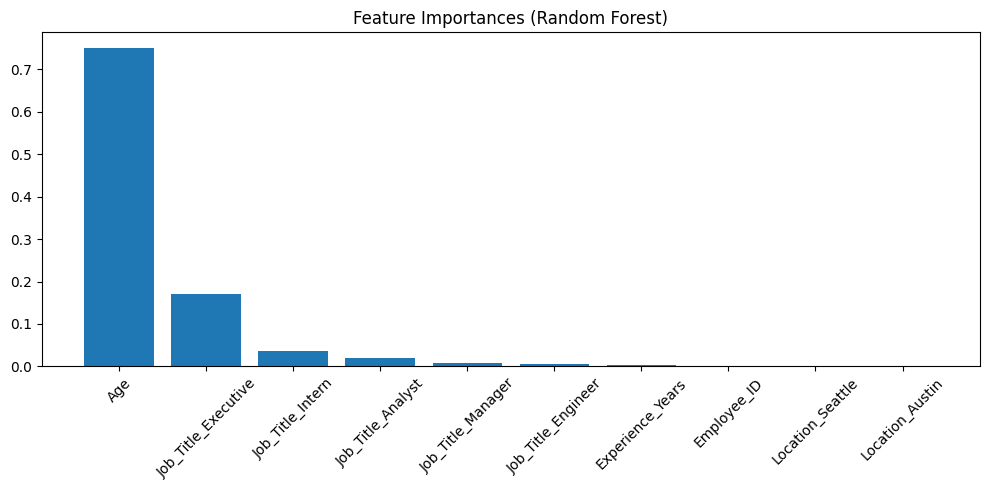

In [42]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', rf)
])
pipeline_rf.fit(X_train, y_train)

feature_names = numeric_features + list(pipeline_rf.named_steps['preprocessor']
    .named_transformers_['cat'].get_feature_names_out(categorical_features))

importances = pipeline_rf.named_steps['regressor'].feature_importances_

# Plot
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,5))
plt.title('Feature Importances (Random Forest)')
plt.bar(range(10), importances[indices][:10], align='center')
plt.xticks(range(10), [feature_names[i] for i in indices[:10]], rotation=45)
plt.tight_layout()
plt.show()


In [43]:
from sklearn.ensemble import StackingRegressor

stack = StackingRegressor(
    estimators=[
        ('rf', RandomForestRegressor(random_state=42)),
        ('knn', KNeighborsRegressor())
    ],
    final_estimator=RandomForestRegressor(n_estimators=50, random_state=42)
)

ens_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', stack)
])
ens_pipeline.fit(X_train, y_train)

y_ens_pred = ens_pipeline.predict(X_test)
rmse_ensemble = np.sqrt(mean_squared_error(y_test, y_ens_pred))
print(f"Stacked Ensemble Test RMSE: {rmse_ensemble:.2f}")


Stacked Ensemble Test RMSE: 5031.72


In [44]:
# %%writefile salary_predictor_app.py

# import streamlit as st
# import pandas as pd
# import joblib

# # Inject dark theme styling & smooth transitions CSS
# st.markdown("""
# <style>
# /* General dark background and light text */
# body, .css-18e3th9, .css-1d391kg {
#     background-color: #121212;
#     color: #fafafa;
#     transition: background-color 0.5s ease, color 0.5s ease;
# }

# /* Container background with shadow and rounded corners */
# .stContainer > div:not(.stAlert) {
#     background-color: #1e1e1e !important;
#     padding: 20px;
#     border-radius: 12px;
#     box-shadow: 0 4px 15px rgba(0,0,0,0.6);
#     transition: background-color 0.5s ease;
# }

# /* Input and select box styling */
# input[type="text"], input[type="number"], select {
#     background-color: #333333 !important;
#     color: #fafafa !important;
#     border: 1px solid #555555 !important;
#     border-radius: 6px;
#     padding: 10px;
#     transition: background-color 0.3s ease, border-color 0.3s ease;
# }

# /* Input focus effect */
# input[type="text"]:focus, input[type="number"]:focus, select:focus {
#     border-color: #1f77b4 !important;
#     background-color: #2c2c2c !important;
#     outline: none;
# }

# /* Button styling */
# button[kind="primary"] {
#     background-color: #1f77b4 !important;
#     border-radius: 8px;
#     padding: 12px 24px;
#     font-weight: bold;
#     text-transform: uppercase;
#     transition: background-color 0.3s ease, transform 0.2s ease;
#     color: white !important;
# }

# /* Button hover effect */
# button[kind="primary"]:hover {
#     background-color: #005f96 !important;
#     transform: scale(1.05);
# }

# /* Prediction result container */
# .prediction-result {
#     background-color: #263238;
#     padding: 20px;
#     border-radius: 10px;
#     max-width: 700px;
#     margin: 20px auto;
#     color: #fafafa;
#     box-shadow: 0 2px 10px rgba(31, 119, 180, 0.7);
#     transition: background-color 0.5s ease;
# }

# /* Scroll into view (optional) */
# html {
#   scroll-behavior: smooth;
# }
# </style>
# """, unsafe_allow_html=True)

# # --- Load model and rest of your app code ---
# model = joblib.load('knn_salary_pipeline.pkl')

# st.set_page_config(
#     page_title="💼 Employee Salary Predictor",
#     page_icon="💼",
#     layout="wide",
#     initial_sidebar_state="expanded"
# )

# st.title("💼 Employee Salary Predictor")
# st.markdown("Welcome! Please enter employee details below to predict their expected salary.")

# with st.container():
#     st.subheader("Employee Details Input")
#     col1, col2 = st.columns([1, 1])

#     with col1:
#         employee_id = st.text_input("🔖 Employee ID", value="", max_chars=20, help="Enter employee ID")
#         name = st.text_input("👤 Employee Name", value="", max_chars=50, help="Enter employee full name")
#         age = st.number_input("🎂 Age", min_value=18, max_value=70, value=30, step=1, format="%d", help="Employee age in years")
#         gender = st.selectbox("⚧ Gender", options=["Male", "Female"], help="Select gender")
#         department = st.selectbox("🏢 Department", options=[
#             "Sales", "Engineering", "Marketing", "Finance", "HR", "Operations", "IT", "Admin"], help="Select department")

#     with col2:
#         job_title = st.text_input("💼 Job Title", value="Software Engineer", max_chars=100, help="Enter the job title")
#         experience_years = st.number_input("⏳ Experience (Years)", min_value=0, max_value=50, value=5, step=1, format="%d", help="Total years of relevant experience")
#         education_level = st.selectbox("🎓 Education Level", options=["Bachelor", "Master", "PhD"], help="Select highest education level")
#         location = st.selectbox("📍 Location", options=["New York", "San Francisco", "Chicago", "Austin", "Seattle", "Boston", "Atlanta"], help="Select work location")

#     input_df = pd.DataFrame([{
#         'Age': age,
#         'Gender': gender,
#         'Department': department,
#         'Job_Title': job_title,
#         'Experience_Years': experience_years,
#         'Education_Level': education_level,
#         'Location': location,
#         'Name': name,
#         'Employee_ID': employee_id
#     }])

#     with st.expander("Preview Input Data"):
#         st.dataframe(input_df, use_container_width=True)

# predict_button = st.button("🔮 Predict Salary", use_container_width=True)

# if predict_button:
#     try:
#         pred_salary = model.predict(input_df)[0]

#         # Styled prediction result container via HTML div with class
#         st.markdown(
#             f"""
#             <div class="prediction-result" tabindex="0">
#                 <h2 style="text-align:center; color:#1f77b4;">💰 Prediction Result</h2>
#                 <p style="font-size:18px;"><b>Employee Name:</b> {name if name else 'N/A'}</p>
#                 <p style="font-size:18px;"><b>Employee ID:</b> {employee_id if employee_id else 'N/A'}</p>
#                 <p style="font-size:22px; font-weight:bold; color:#d55e00;">Predicted Salary: ${pred_salary:,.2f}</p>
#             </div>
#             """,
#             unsafe_allow_html=True
#         )

#     except Exception as e:
#         st.error(f"Prediction failed: {e}")

# st.markdown("---")
# with st.container():
#     st.subheader("📂 Batch Salary Prediction")
#     uploaded_file = st.file_uploader("Upload a CSV file with employee details", type="csv", key="batch_upload")

#     if uploaded_file is not None:
#         try:
#             batch_df = pd.read_csv(uploaded_file)
#             st.markdown("**Uploaded Data Preview:**")
#             st.dataframe(batch_df.head(), use_container_width=True)

#             batch_preds = model.predict(batch_df)
#             batch_df['Predicted_Salary'] = batch_preds

#             st.markdown("**Prediction Results:**")
#             st.dataframe(batch_df.head(), use_container_width=True)

#             csv = batch_df.to_csv(index=False).encode('utf-8')
#             st.download_button("⬇️ Download Predictions as CSV", data=csv, file_name='batch_salary_predictions.csv', mime='text/csv')

#         except Exception as e:
#             st.error(f"Batch prediction failed: {e}")


In [89]:
%%writefile salary_predictor_app.py

import streamlit as st
import pandas as pd
import joblib

# --- Dark Theme and Container Styling (no input element overrides) ---

st.markdown("""
<style>
body, .stApp {
    background-color: #ffffff !important;  /* light background */
    color: #000000 !important;             /* dark text */
}

/* Containers & cards styling for light theme */
.stContainer > div, .card, .prediction-result {
    background: #f9f9f9 !important;        /* very light gray container */
    border-radius: 12px;
    margin-bottom: 24px;
    padding: 13px 19px;
    box-shadow: 0 0 5px #ccccccAA;
    border: 1px solid #e0e0e0;
}

/* Uniform input, textarea, and select styles: white bg, black text */
input, textarea, select,
.stSelectbox div[role="textbox"],
.stMultiSelect div[role="textbox"] {
    background-color: #ffffff !important; /* WHITE background */
    color: #000000 !important;            /* BLACK text */
    border: 1px solid #ccc !important;
    border-radius: 6px !important;
    font-size: 1rem !important;
    padding: 10px 13px !important;
    box-sizing: border-box;
    transition: border-color 0.15s;
}

/* Focus styling for all inputs */
input:focus, textarea:focus, select:focus,
.stSelectbox div[role="textbox"]:focus,
.stMultiSelect div[role="textbox"]:focus {
    border-color: #4285f4 !important;
    outline: none !important;
}

/* Dropdown option list styling */
select option {
    background-color: #ffffff !important; /* white options background */
    color: #000000 !important;            /* black options text */
}

/* Streamlit's custom dropdown options */
.stSelectbox .css-1wa3eu0-option,
.stSelectbox [role="option"],
.stMultiSelect .css-1wa3eu0-option,
.stMultiSelect [role="option"] {
    background-color: #ffffff !important;
    color: #000000 !important;
}

/* Placeholder text for selects */
.stSelectbox .css-1wa3eu0-placeholder,
.stMultiSelect .css-1wa3eu0-placeholder {
    color: #666666 !important; /* dark gray placeholders */
}

/* Labels, headers */
h1, h2, h3, label, .st-bd, .stTextInput>div>label {
    color: #000000 !important;
    font-family: 'Segoe UI', 'Roboto', sans-serif;
}

/* Buttons */
.stButton>button {
    font-size: 1rem;
    font-weight: 600;
    border-radius: 6px;
    padding: 0.7rem 1.4rem;
    background: #4285f4; /* Google-blue */
    color: #fff;
    border: none;
    margin-top: 10px;
    margin-bottom: 10px;
    transition: background 0.18s;
}
.stButton>button:hover {
    background: #3367d6;
}

/* Prediction result card */
.prediction-result {
    background: #f0f0f0 !important;
    border-radius: 10px;
    color: #000000;
    padding: 22px 10px 18px 10px;
    margin: 20px auto 8px auto;
    text-align: center;
    max-width: 540px;
    box-shadow: 0 0 10px #bbbbbb88;
}
</style>
""", unsafe_allow_html=True)







# --- Model Loading ---
model = joblib.load('knn_salary_pipeline.pkl')

st.set_page_config(
    page_title="💼 Employee Salary Predictor",
    page_icon="💼",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Title
st.title("💼 Employee Salary Predictor")
st.markdown("<span style='font-size:20px;'>Enter employee information below for instant, professional salary prediction.</span>", unsafe_allow_html=True)

# Input Section
with st.container():
    st.subheader("Employee Details")
    col1, col2 = st.columns([1, 1])

    with col1:
        employee_id = st.text_input("🔖 Employee ID", value="", max_chars=20)
        name = st.text_input("👤 Employee Name", value="", max_chars=50)
        age = st.number_input("🎂 Age", min_value=18, max_value=70, value=30, step=1, format="%d")
        gender = st.selectbox("⚧ Gender", options=["Male", "Female"])
        department = st.selectbox("🏢 Department", options=[
            "Sales", "Engineering", "Marketing", "Finance", "HR", "Operations", "IT", "Admin"])

    with col2:
        job_title = st.text_input("💼 Job Title", value="Software Engineer", max_chars=100)
        experience_years = st.number_input("⏳ Experience (Years)", min_value=0, max_value=50, value=5, step=1, format="%d")
        education_level = st.selectbox("🎓 Education Level", options=["Bachelor", "Master", "PhD"])
        location = st.selectbox("📍 Location", options=[
            "New York", "San Francisco", "Chicago", "Austin", "Seattle", "Boston", "Atlanta"])

    with st.expander("💡 Preview Input Data", expanded=True):
        input_df = pd.DataFrame([{
            'Age': age,
            'Gender': gender,
            'Department': department,
            'Job_Title': job_title,
            'Experience_Years': experience_years,
            'Education_Level': education_level,
            'Location': location,
            'Name': name,
            'Employee_ID': employee_id
        }])
        st.dataframe(input_df, use_container_width=True, hide_index=True)

# Prediction Output
predict_button = st.button("🔮 Predict Salary", use_container_width=True)
if predict_button:
    try:
        pred_salary = model.predict(input_df)[0]
        st.markdown(
            f"""
            <div class="prediction-result">
                <h2>💰 Prediction Result</h2>
                <div style='font-size:19px;text-align:left;'>
                  <b>Employee Name:</b> {name if name else 'N/A'}<br>
                  <b>Employee ID:</b> {employee_id if employee_id else 'N/A'}<br>
                </div>
                <hr style='border-color:#2186FF;margin:8px auto;'>
                <p style="font-size:29px;color:#2186FF;font-weight:bold;">
                    Predicted Salary: <span style="color:#fd576c;">${pred_salary:,.2f}</span>
                </p>
            </div>
            """,
            unsafe_allow_html=True
        )
    except Exception as e:
        st.error(f"Prediction failed: {e}")

st.markdown("---")
with st.container():
    st.subheader("📂 Batch Salary Prediction")
    uploaded_file = st.file_uploader("Upload a CSV with employee details before uploading just modified the column name to Id -> Employee_ID; Name -> Name;  Age -> Age; Gender -> Gender; Department -> Department; Job_designation -> Job_Title; Experience -> Experience_Years; Educatin -> Education_Level; Location -> Lcation; If you have all the above data, then you can predict the salary for the whole dataset", type="csv", key="batch_upload")
    if uploaded_file is not None:
        try:
            batch_df = pd.read_csv(uploaded_file)
            st.markdown("**Uploaded Data Preview:**")
            st.dataframe(batch_df.head(), use_container_width=True, hide_index=True)

            batch_preds = model.predict(batch_df)
            batch_df['Predicted_Salary'] = batch_preds

            st.markdown("**Prediction Results:**")
            st.dataframe(batch_df.head(), use_container_width=True, hide_index=True)

            csv = batch_df.to_csv(index=False).encode('utf-8')
            st.download_button(
                "⬇️ Download Predictions as CSV",
                data=csv,
                file_name='batch_salary_predictions.csv',
                mime='text/csv'
            )
        except Exception as e:
            st.error(f"Batch prediction failed: {e}")


Overwriting salary_predictor_app.py


In [ ]:
!streamlit run salary_predictor_app.py